In [253]:
import time
from numpy import cos, pi, exp, e, sqrt
import numpy
from numba import njit
import matplotlib.pyplot as plt

#Реализация алгоритма ETFSS на Python с использованием Numba

In [254]:
n_args_count_ = 2  # количество x-ов, подаваемых в тестовую функцию
iter_max_ = 500  # больше 500 не нужно
number_of_agents_ = 50  # количество агентов популяции (20-40-50 должно быть)
max_weight_ = 100  # максимальный вес рыбы

##Реализация алгоритма

In [255]:
@njit
def main_function(f, generate_agents, n_args_count, iter_max, number_of_agents, max_weight):
    y = 5

    step_ind = numpy.zeros(iter_max)
    step_vol = numpy.zeros(iter_max)
    p_qbest_list = numpy.zeros((iter_max, n_args_count))  # массив p_qbest в разные моменты поколений
    w = numpy.zeros((iter_max, number_of_agents))
    P = numpy.zeros((iter_max, number_of_agents, n_args_count))  # Начальная популяция
    F = numpy.zeros((iter_max, number_of_agents))  # значение функции для каждого агента

    t = 0  # текущий номер поколения
    step_ind[t] = 0.05
    step_vol[t] = 0.05
    w[t] += max_weight / 2
    P[t] = generate_agents(number_of_agents, n_args_count)  # Случано сгенерированное текущее поколение

    p_qbest = P[t][0]
    for i in P[t]:
        if f(p_qbest) > f(i):
            p_qbest = i
    p_qbest_list[t] = p_qbest

    f_t = numpy.zeros(number_of_agents)
    for i in range(number_of_agents):
        f_I = f(P[t][i])
        f_t[i] = f_I
        # f_t.append(f_I)

    # значение функции для каждого агента
    F[t] = f_t

    # макс кол-во иттераций
    # критерий останова может быть и другим
    # t не только как поколение, но и кол-во иттераций
    while t < iter_max - 1:
        t += 1
        step_ind[t] = step_ind[0] * exp(-y * t / iter_max)
        step_vol[t] = step_vol[0] * exp(-y * t / iter_max)

        P[t] = numpy.copy(P[t - 1])
        w[t] = numpy.copy(w[t - 1])
        # для каждого агента выполнить
        for i in range(number_of_agents):
            r1 = numpy.random.uniform(0, 1, n_args_count)

            P[t][i] += (r1 * step_ind[t])

            F[t][i] = f(P[t][i])  # значение f для P_it
            if F[t][i] >= F[t - 1][i]:
                P[t][i] = P[t - 1][i]
                F[t][i] = f(P[t][i])

        for i in range(number_of_agents):
            if max(F[t] - F[t - 1]) != 0:
                # кормление
                w[t][i] += (F[t][i] - F[t - 1][i]) / (max(F[t] - F[t - 1]))

        # вычисляем вектор коллективно-инстинктивного перемещения
        I_t = numpy.zeros(n_args_count)

        P_mul_F = numpy.zeros(
            (number_of_agents, n_args_count))

        delta_F = F[t] - F[t - 1]
        for i in range(number_of_agents):
            P_mul_F[i] = (P[t][i] - P[t - 1][i]) * delta_F[i]

        for j in range(n_args_count):
            s = numpy.sum(P_mul_F[:][j])
            I_t[j] = s
        I_t /= numpy.sum(delta_F)
        # Применяем оператор коллективно-инстинктивного перемещения к каждому агенту
        P[t] += I_t

        # Вычисляем Бариоцентр
        B_t = numpy.zeros(n_args_count)
        for j in range(n_args_count):
            sm = 0
            for i in range(number_of_agents):
                sm += P[t][i][j] * w[t][i]
            B_t[j] = sm
        sm2 = numpy.sum(w[t])
        B_t /= sm2

        # для каждого агента выполнять
        for i in range(number_of_agents):
            r2 = numpy.random.uniform(0, 1, n_args_count)
            if numpy.sum(w[t]) > numpy.sum(w[t - 1]):
                for j in range(len(P[t][0])):
                    P[t][i][j] -= step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))
            else:
                for j in range(len(P[t][0])):
                    P[t][i][j] += step_vol[t] * r2[j] * (P[t][i][j] - B_t[j]) / abs((P[t][i][j] - B_t[j]))

        p_qbest_t = P[t][0]
        for i in P[t]:
            if f(p_qbest_t) > f(i):
                p_qbest_t = i
        if f(p_qbest_t) < f(p_qbest):
            p_qbest = p_qbest_t
        p_qbest_list[t] = p_qbest

    return p_qbest_list

In [256]:
def draw_graphic(f_val, functon_name, iter_max):
    plt.grid(color="black", linestyle="--", linewidth=0.5)
    plt.plot(numpy.arange(iter_max), f_val, color='fuchsia')
    plt.xlabel("Номер поколения")
    plt.ylabel("f(p_qbest)")
    plt.title(f'Тестовая функция {functon_name}')
    plt.show()

In [278]:
def draw_distribution_graphic(best_values, function_name, c):
    plt.title("Распределение для функции " + function_name)
    plt.xlabel("Номер теста")
    plt.ylabel("Лучшее найденное значение")
    plt.scatter(numpy.arange(10), best_values, c="black")
    plt.plot(numpy.arange(10), numpy.zeros(10) + c, c="fuchsia")
    plt.fill_between(numpy.arange(10),
                     numpy.zeros(10)+c - 2,
                     numpy.zeros(10)+c + 2,
                     color="fuchsia",
                     alpha=0.2)
    plt.show()

In [258]:
def start_test(f_, generate_agents_, function_name, n_args_count, iter_max, number_of_agents, max_weight, c=0):
    best_qbest_tests = numpy.zeros(10) # лучшие значения алгоритма в результате 10 запусков
    for i in range(10):
        start = time.time()
        best_lst = main_function(f_, generate_agents_, n_args_count, iter_max, number_of_agents, max_weight)
        best = best_lst[-1]
        end = time.time() - start
        # best_qbest_tests.append(f(best))
        best_qbest_tests[i] = f_(best)
        print(f'------------------------TEST NUMBER: {i + 1}------------------------')
        print(f'Coordinates of p_qbest:\t\t\t{best}')
        print(f'The function value of pqbest:\t\t{f_(best)}')
        print(f'Algorithm running time:\t\t\t{end} s')
        # f_val = [f(i) for i in best_lst]
        f_val = numpy.zeros(iter_max)
        for i in range(iter_max):
            f_val[i] = f_(best_lst[i])
        draw_graphic(f_val, function_name, iter_max)
    draw_distribution_graphic(best_qbest_tests, function_name, c)

##Тестовая функция Растригина
![picture_of_Rastrigen](src/растригина.png)

In [259]:
@njit
def f1(x):  # Тестовая функция Растригина
    A = 10
    result = 0
    for i in x:
        result += i * i - A * cos(2 * pi * i)
    result += A * len(x)

    return result

##Генерация начальных агентов

In [260]:
@njit
def generate_agents1(number_of_agents, n_args_count):
    return numpy.random.uniform(-5.12, 5.12, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-1.00674433  0.00602552]
The function value of pqbest:		1.029713516784426
Algorithm running time:			4.474588871002197 s


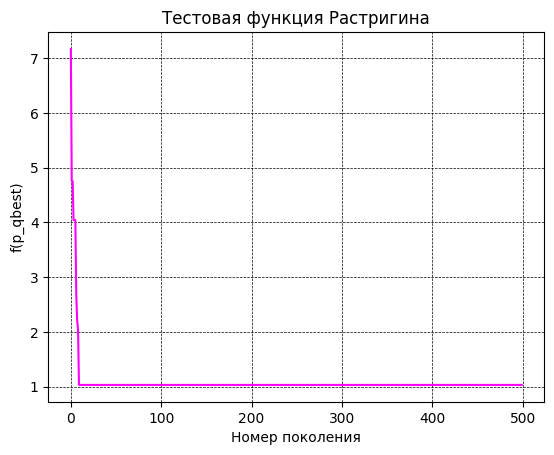

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.97678187 -0.99792995]
The function value of pqbest:		2.0570346952632548
Algorithm running time:			0.031986236572265625 s


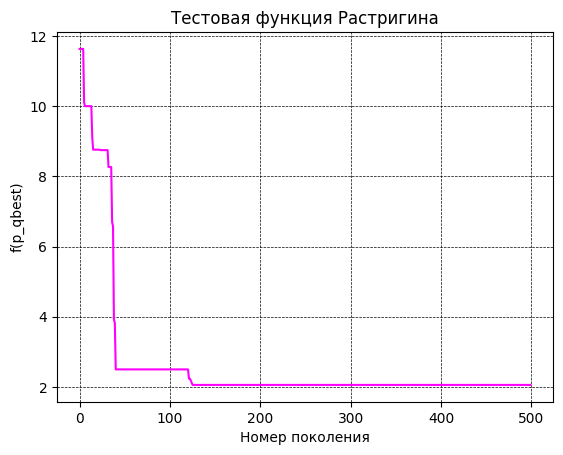

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.01344689 -0.0170679 ]
The function value of pqbest:		0.09359090440482376
Algorithm running time:			0.03201723098754883 s


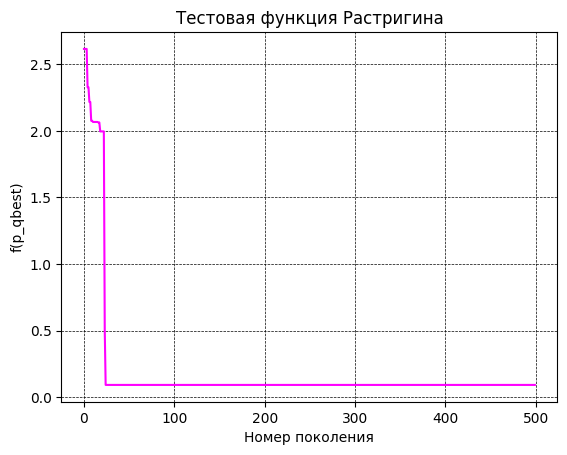

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-1.00465247  0.02332632]
The function value of pqbest:		1.1213553225439838
Algorithm running time:			0.03199338912963867 s


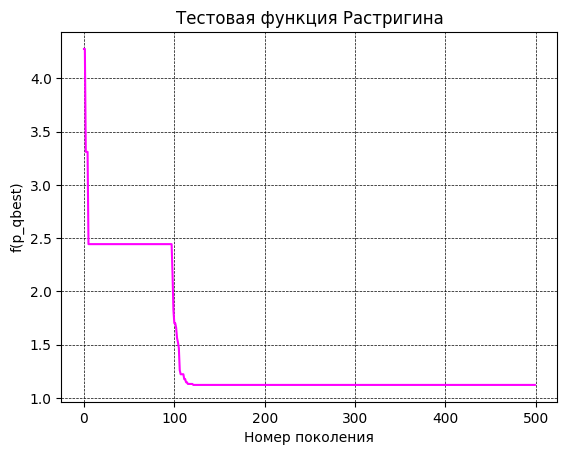

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.00868434 -1.05271408]
The function value of pqbest:		1.6666774693640392
Algorithm running time:			0.032007455825805664 s


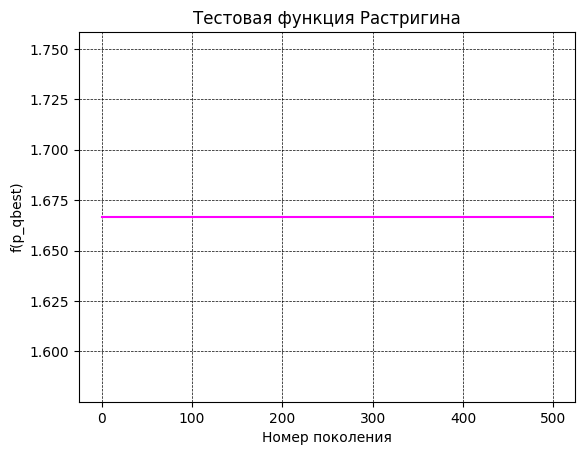

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.00761341 1.0788009 ]
The function value of pqbest:		3.391421870337247
Algorithm running time:			0.031987905502319336 s


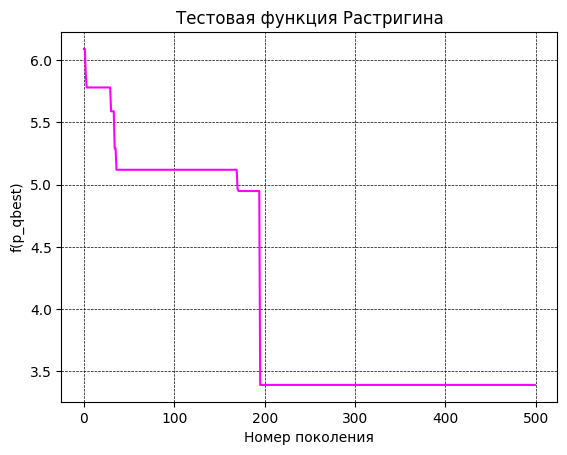

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.00077469 -0.00349746]
The function value of pqbest:		0.002545744717970422
Algorithm running time:			0.024018287658691406 s


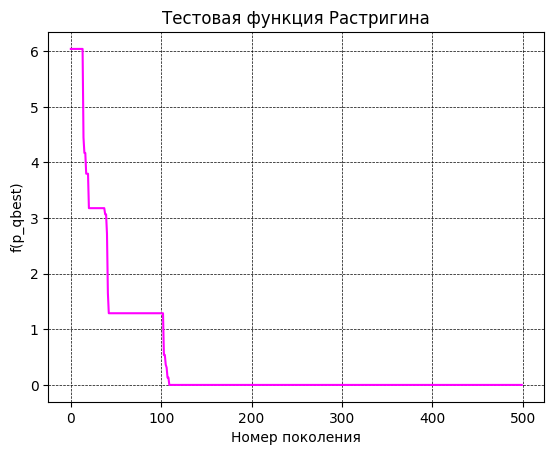

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[-1.08343547  1.07103136]
The function value of pqbest:		4.643407895025106
Algorithm running time:			0.032002925872802734 s


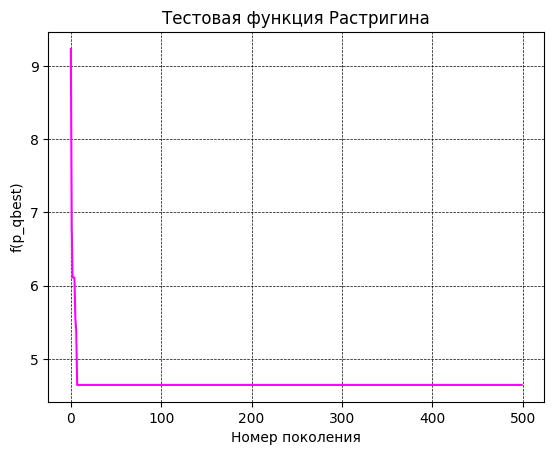

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[-0.00252091  0.00286051]
The function value of pqbest:		0.002884057288248698
Algorithm running time:			0.03198504447937012 s


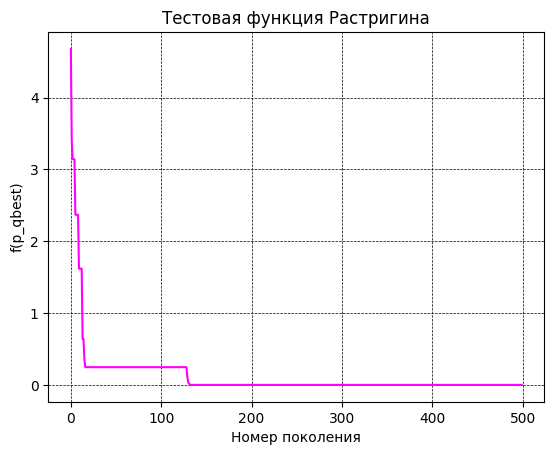

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.99046086 -1.02431505]
The function value of pqbest:		2.1646660138582448
Algorithm running time:			0.03200078010559082 s


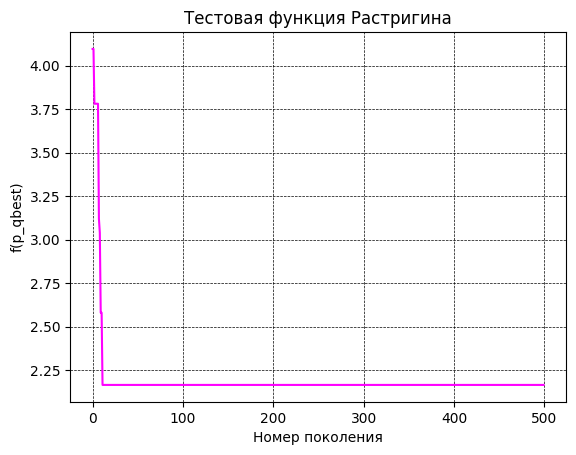

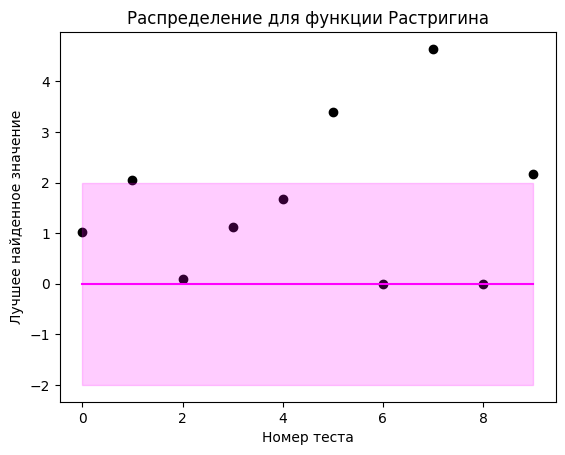

In [261]:
start_test(f1, generate_agents1, "Растригина", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Экли
![picture_of_Ekli](src/Экли.png)


In [262]:
@njit
def f2(x):  # Тестовая функция Экли
    result = -20 * exp(-0.2 * sqrt(0.5 * (x[0] * x[0] + x[1] * x[1]))) \
             - exp(0.5 * (cos(2 * pi * x[0]) + cos(2 * pi * x[1]))) + e + 20
    return result

##Генерация начальных агентов

In [263]:
@njit
def generate_agents2(number_of_agents, n_args_count):
    return numpy.random.uniform(-5, 5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[ 0.03889526 -0.00577935]
The function value of pqbest:		0.15188113146066584
Algorithm running time:			3.4803411960601807 s


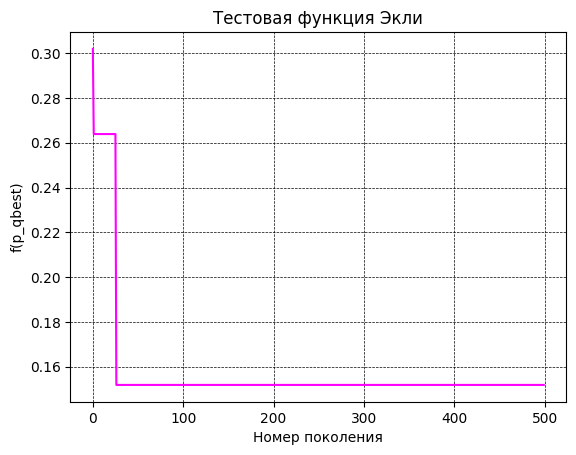

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.96102581  0.01705857]
The function value of pqbest:		2.589863206183491
Algorithm running time:			0.0240018367767334 s


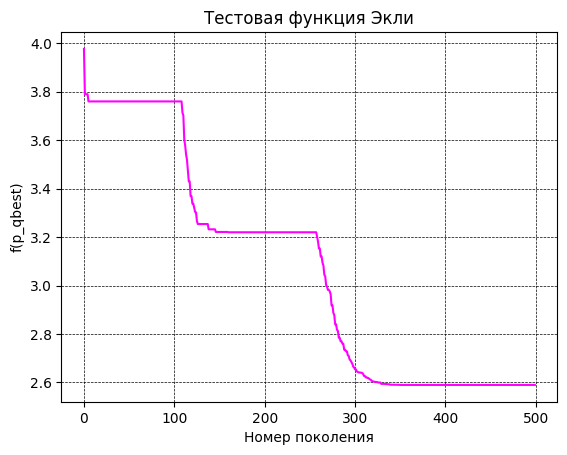

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.19831151  0.09010617]
The function value of pqbest:		1.5362110958192936
Algorithm running time:			0.024002552032470703 s


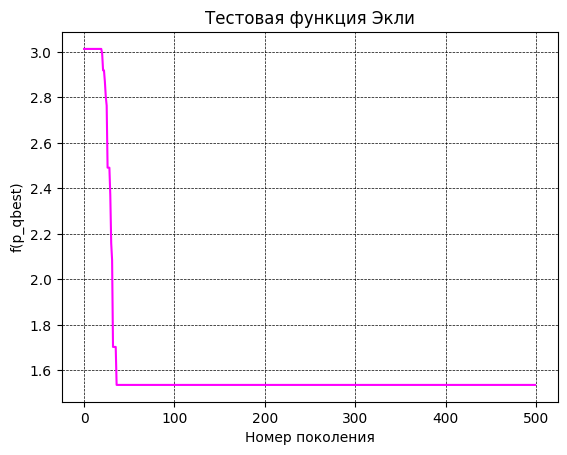

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[ 0.02170907 -0.13784011]
The function value of pqbest:		0.8402541383980981
Algorithm running time:			0.023998737335205078 s


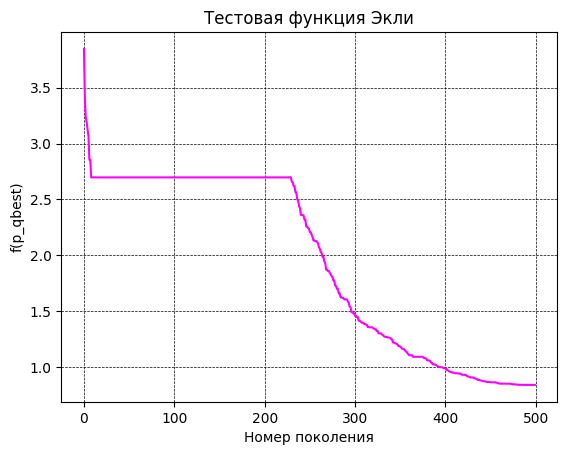

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.01119938  0.01669852]
The function value of pqbest:		0.06760466335153126
Algorithm running time:			0.024005413055419922 s


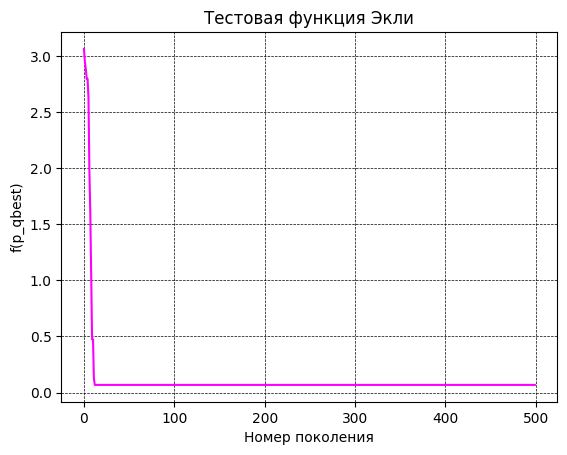

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.16438088 0.01210577]
The function value of pqbest:		1.0520148941804486
Algorithm running time:			0.02400517463684082 s


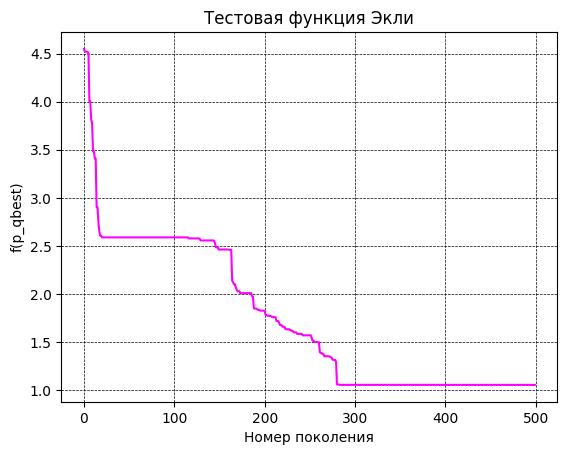

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.00184546 0.00354342]
The function value of pqbest:		0.011725098726934391
Algorithm running time:			0.016018152236938477 s


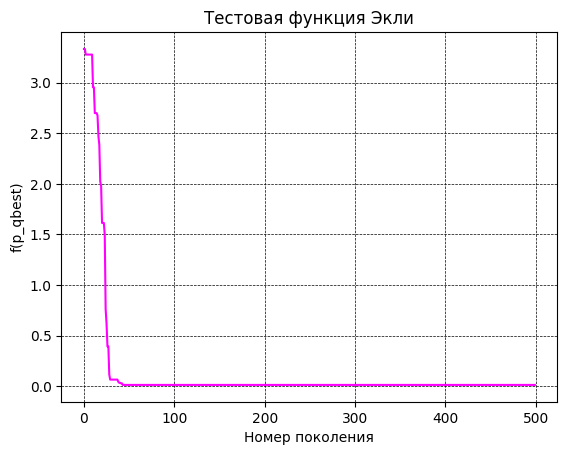

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.00474411 0.94719629]
The function value of pqbest:		2.581125789137406
Algorithm running time:			0.024003028869628906 s


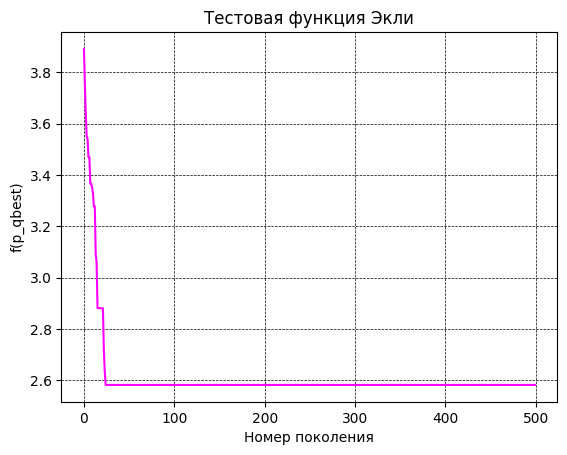

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.10343245 -0.03745031]
The function value of pqbest:		0.6057273650217674
Algorithm running time:			0.023994922637939453 s


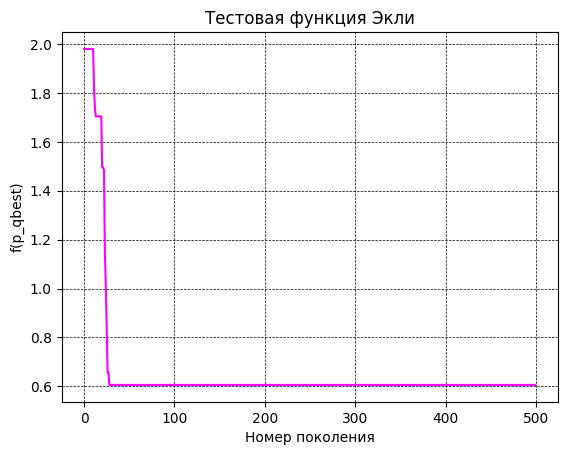

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.13994894 -0.101859  ]
The function value of pqbest:		1.1477229078512003
Algorithm running time:			0.023988723754882812 s


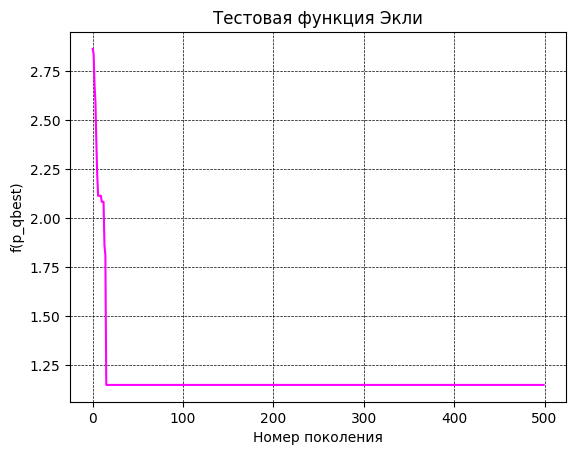

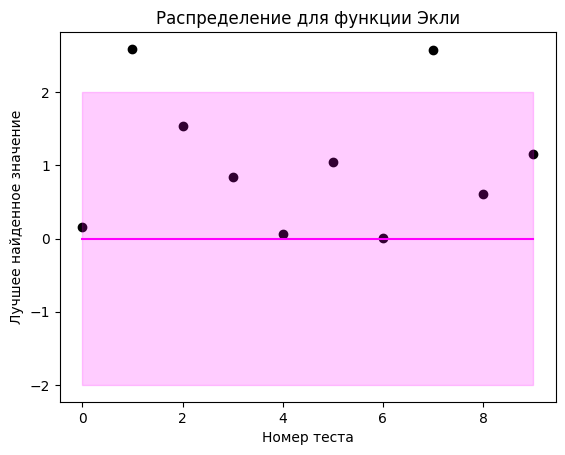

In [264]:
start_test(f2, generate_agents2, "Экли", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Сферы
![picture_of_Sphere](src/сфера.png)

In [265]:
@njit
def f3(x):  # Тестовая функция Сферы
    result = 0
    for i in x:
        result += i * i
    return result

##Генерация начальных агентов

In [266]:
@njit
def generate_agents3(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.30335119  0.4952545 ]
The function value of pqbest:		0.33729896997603404
Algorithm running time:			2.875856876373291 s


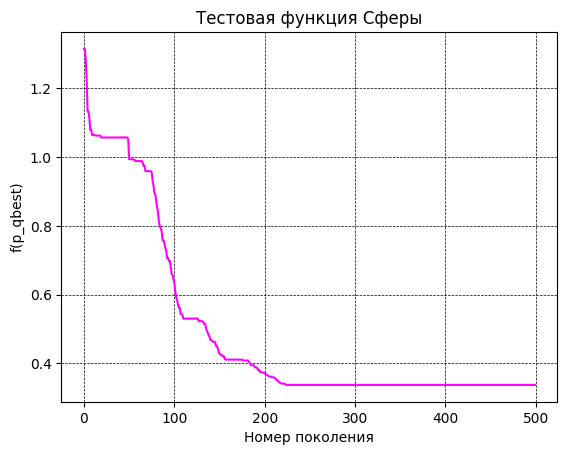

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.18352905  0.24883044]
The function value of pqbest:		0.09559949820352534
Algorithm running time:			0.016013622283935547 s


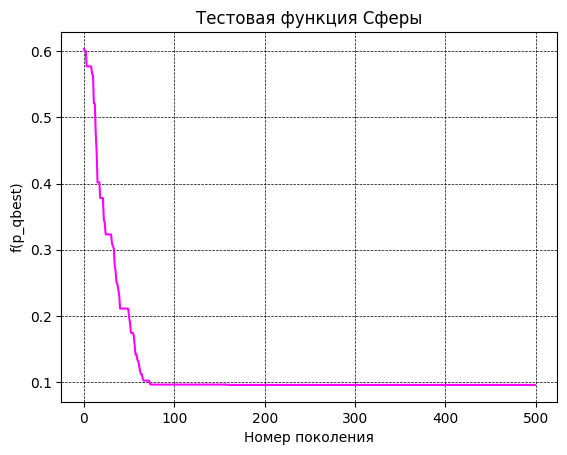

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-0.40420789 -0.90517179]
The function value of pqbest:		0.9827199850227895
Algorithm running time:			0.016019821166992188 s


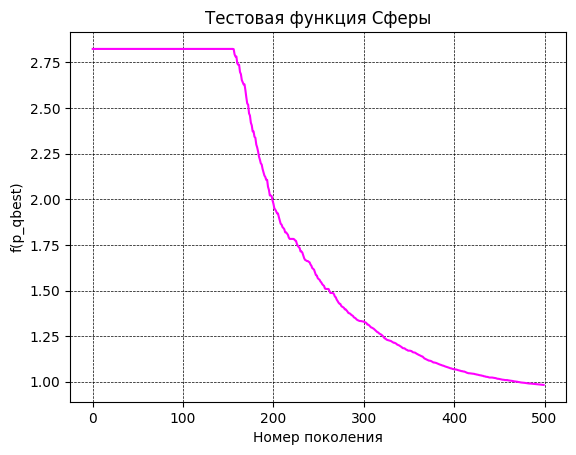

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.32817446 0.00713731]
The function value of pqbest:		0.10774941503469707
Algorithm running time:			0.016006946563720703 s


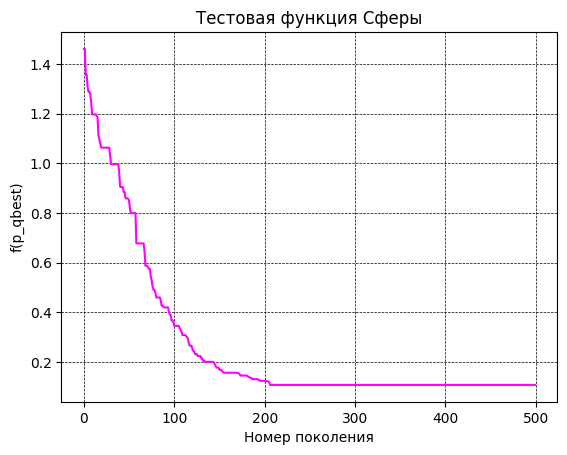

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[-0.08459563  0.19730084]
The function value of pqbest:		0.04608404080213718
Algorithm running time:			0.023984909057617188 s


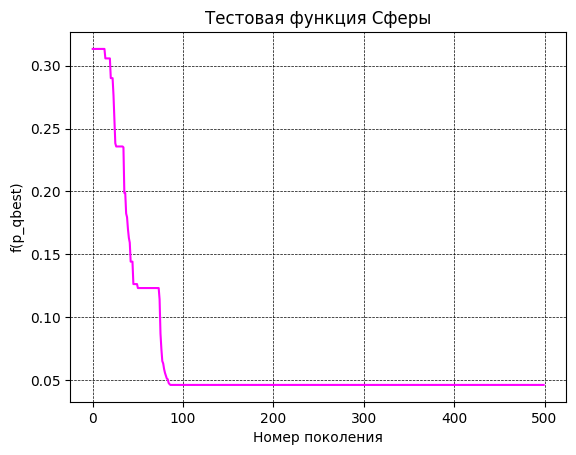

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[0.099367  0.2029998]
The function value of pqbest:		0.051082721297362924
Algorithm running time:			0.0240023136138916 s


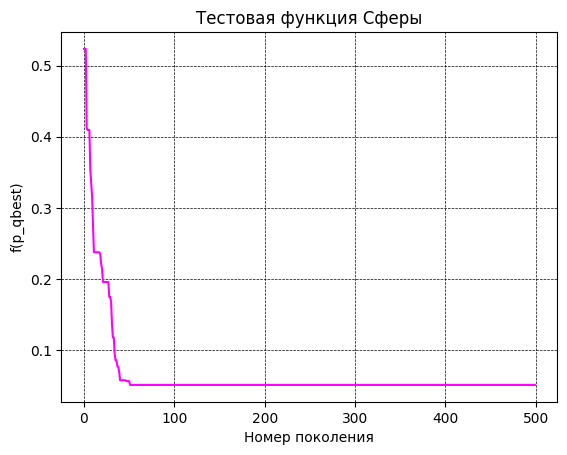

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.77885035  0.03855961]
The function value of pqbest:		0.608094711665415
Algorithm running time:			0.016011476516723633 s


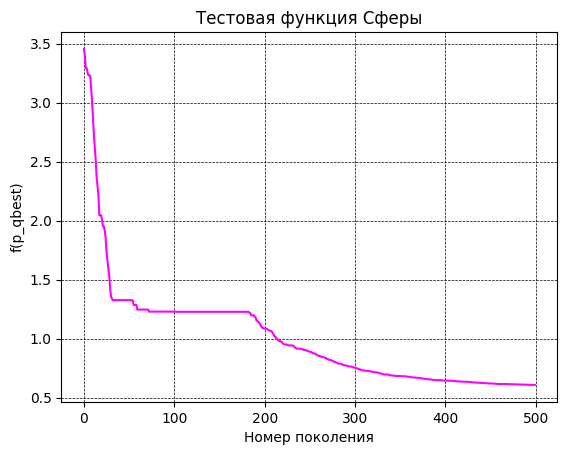

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.00399146 -0.0008669 ]
The function value of pqbest:		1.6683271548060973e-05
Algorithm running time:			0.016002416610717773 s


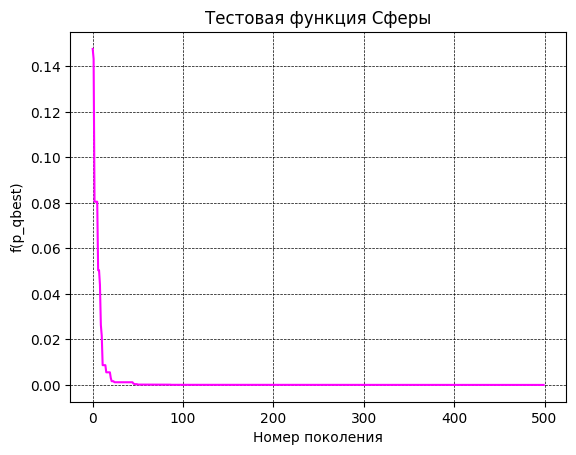

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[0.02253538 0.13793692]
The function value of pqbest:		0.01953443763604567
Algorithm running time:			0.01600193977355957 s


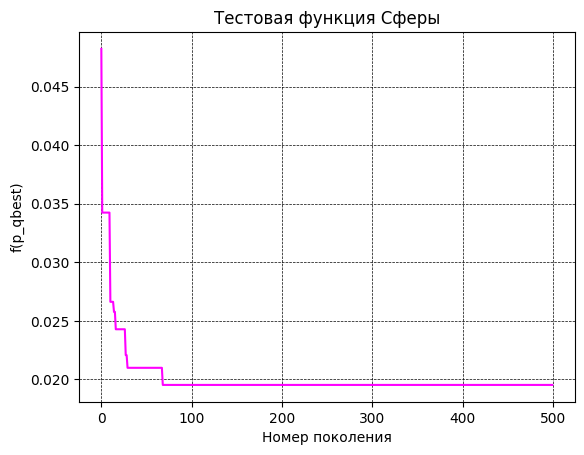

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[-0.24104913  0.0635754 ]
The function value of pqbest:		0.0621465126637644
Algorithm running time:			0.02400803565979004 s


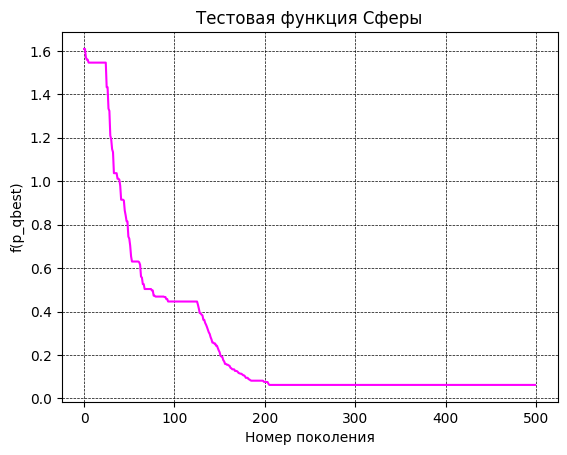

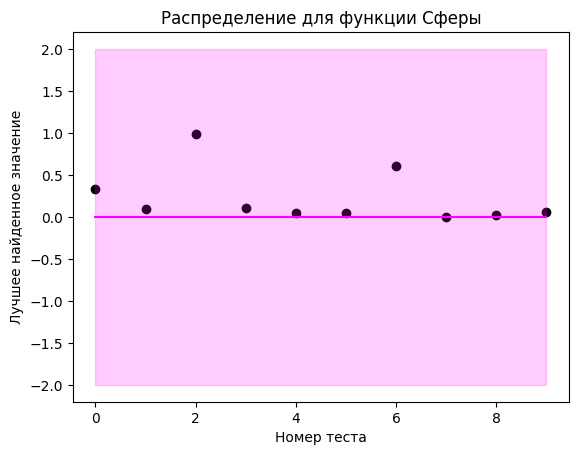

In [267]:
start_test(f3, generate_agents3, "Сферы", n_args_count_, iter_max_, number_of_agents_, max_weight_)



##Тестовая функция Розенбока
![picture_of_Rosenbock](src/розенбока.png)

In [268]:
@njit
def f4(x):  # Тестовая функция Розенбока
    result = 0
    n = len(x)
    for i in range(n-1):
        result += 100 * (x[i+1] - x[i] ** 2) **2 + (x[i] - 1) **2
    return result

##Генерация начальных агентов

In [269]:
@njit
def generate_agents4(number_of_agents, n_args_count):
    return numpy.random.uniform(-11, 11, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[1.40313274 1.98632109]
The function value of pqbest:		0.1932797954998935
Algorithm running time:			2.861600637435913 s


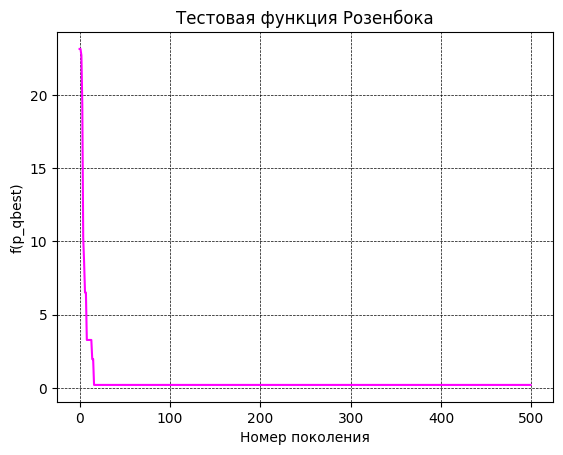

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.5180587  0.23810986]
The function value of pqbest:		0.3239247132060426
Algorithm running time:			0.015930652618408203 s


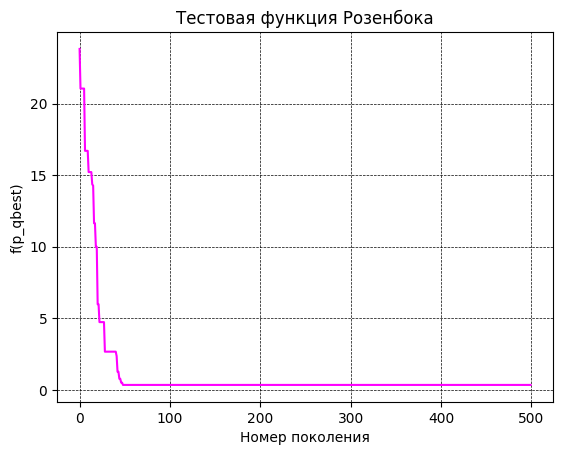

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[-2.38665924  5.70769419]
The function value of pqbest:		11.482805346405524
Algorithm running time:			0.024000883102416992 s


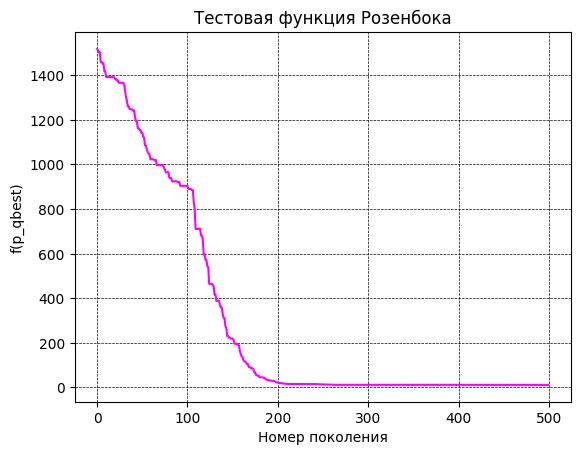

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[1.96231123 3.85368307]
The function value of pqbest:		0.9269535618166683
Algorithm running time:			0.01600193977355957 s


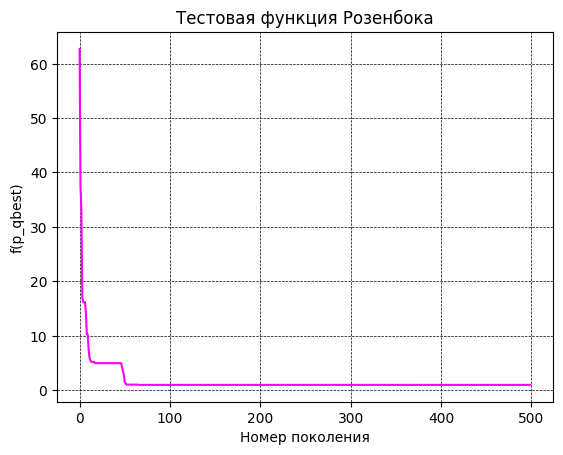

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[1.44245391 2.08421726]
The function value of pqbest:		0.19702143497785551
Algorithm running time:			0.01598954200744629 s


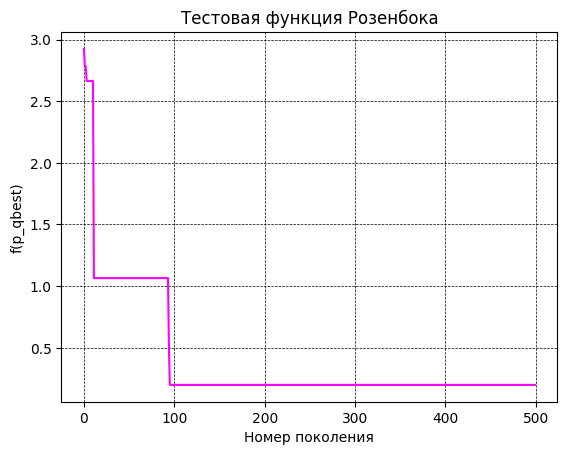

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.29234549 1.60845131]
The function value of pqbest:		0.4662235388188292
Algorithm running time:			0.024000883102416992 s


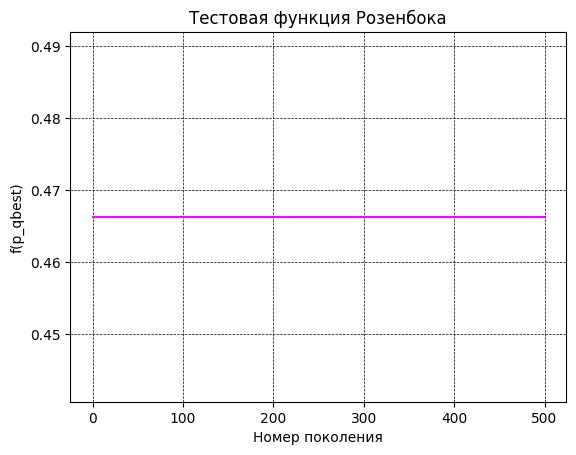

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[3.07509324 9.5133962 ]
The function value of pqbest:		4.633170457899709
Algorithm running time:			0.01599597930908203 s


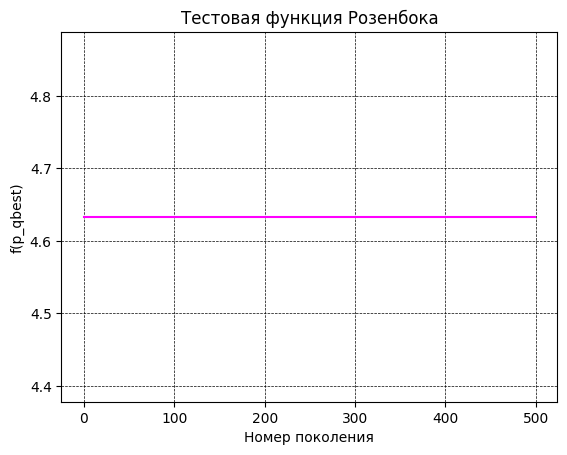

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 3.34948044 11.07811097]
The function value of pqbest:		7.505572156609208
Algorithm running time:			0.016001224517822266 s


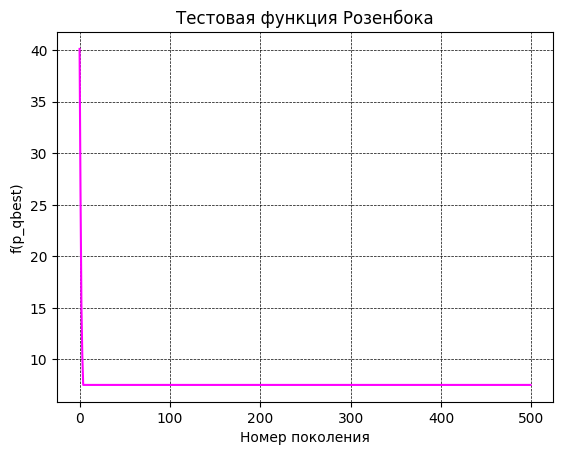

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[2.12803262 4.50340999]
The function value of pqbest:		1.335523183589983
Algorithm running time:			0.01600170135498047 s


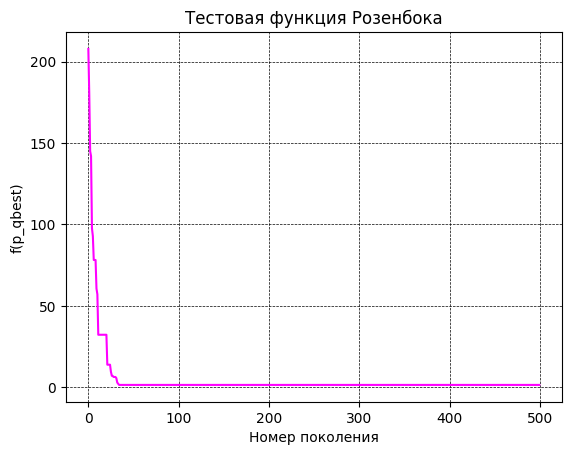

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[0.9711237  0.94178839]
The function value of pqbest:		0.0010009893929894063
Algorithm running time:			0.02513909339904785 s


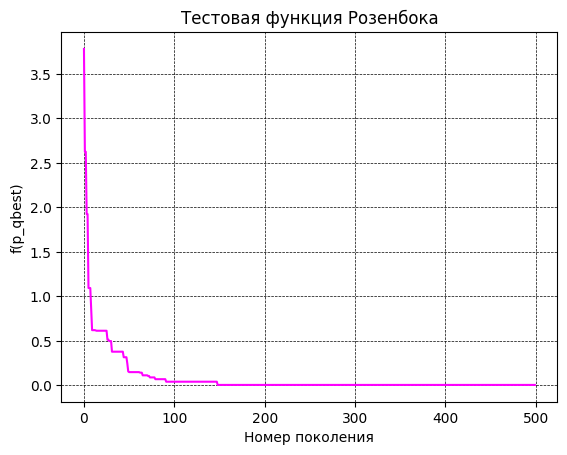

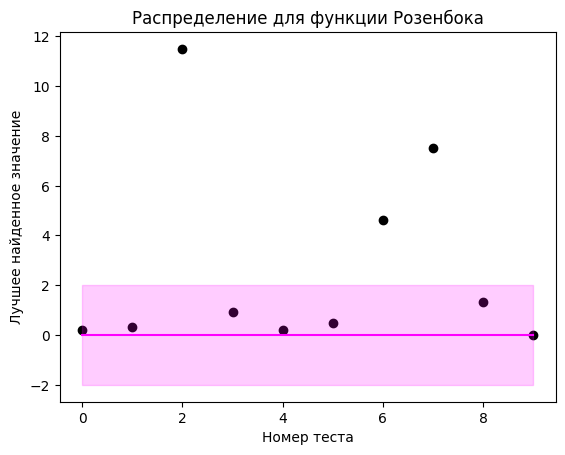

In [270]:
start_test(f4, generate_agents4, "Розенбока", n_args_count_, iter_max_, number_of_agents_, max_weight_)


##Тестовая функция Била
![picture_of_Bila](src/била.png)

In [271]:
@njit
def f5(x):  # Тестовая функция Била
    result = (1.5 - x[0] + x[0] * x[1]) ** 2 + \
             (2.25 - x[0] + x[0] * x[1] ** 2) ** 2 + \
             (2.625 - x[0] + x[0] * x[1] ** 3) ** 2
    return result

In [272]:
@njit
def generate_agents5(number_of_agents, n_args_count):
    return numpy.random.uniform(-4.5, 4.5, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[3.00309696 0.50048805]
The function value of pqbest:		3.3307746092660213e-06
Algorithm running time:			3.025941848754883 s


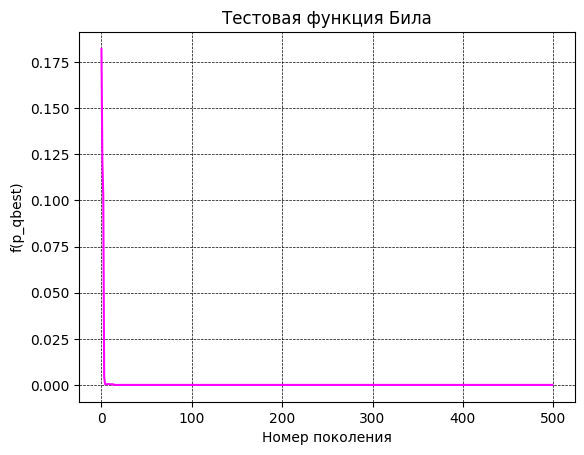

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[3.1130289  0.52643607]
The function value of pqbest:		0.001811101331528528
Algorithm running time:			0.016000986099243164 s


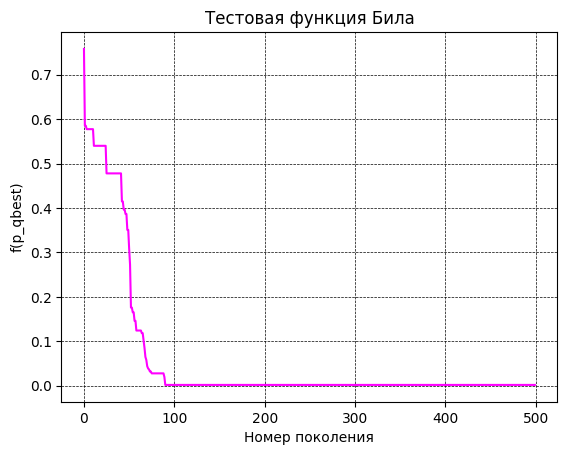

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[3.61241472 0.61654193]
The function value of pqbest:		0.033117254184362566
Algorithm running time:			0.016001462936401367 s


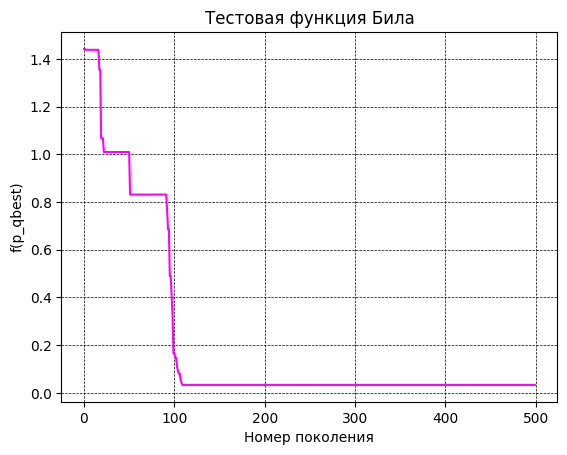

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[3.14832584 0.52980752]
The function value of pqbest:		0.0036391410099725096
Algorithm running time:			0.02287149429321289 s


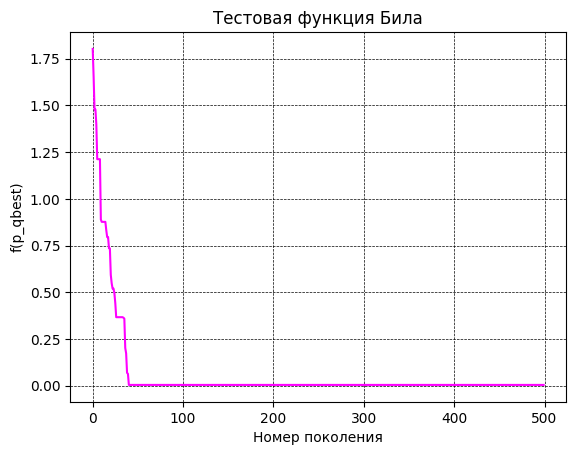

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[2.8252271  0.44690286]
The function value of pqbest:		0.006740186108332654
Algorithm running time:			0.02400040626525879 s


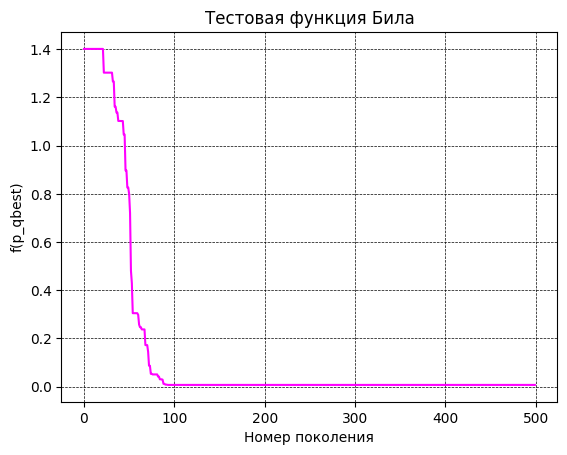

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[3.95487116 0.66602462]
The function value of pqbest:		0.06061167662144302
Algorithm running time:			0.0160062313079834 s


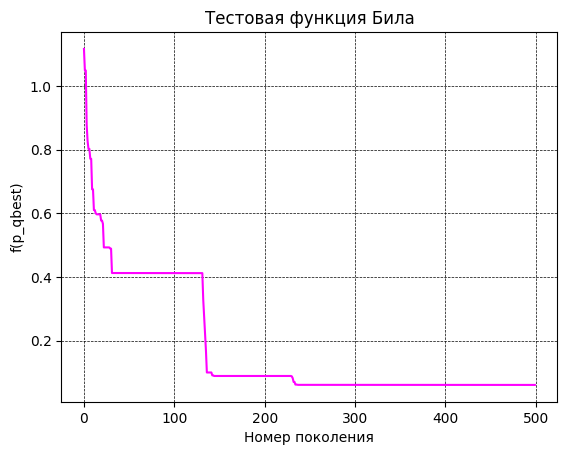

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[3.89417952 0.65615866]
The function value of pqbest:		0.05555859747100135
Algorithm running time:			0.016017913818359375 s


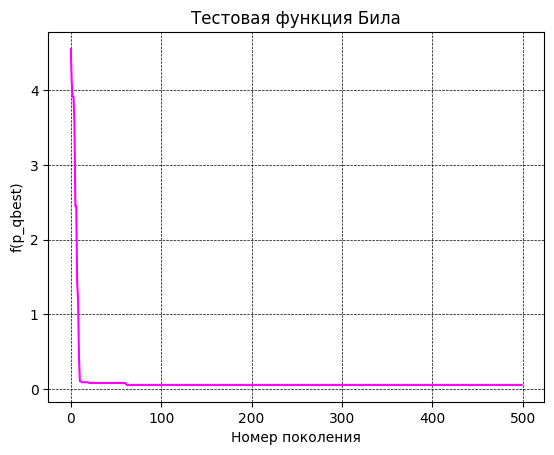

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[4.18280538 0.69272997]
The function value of pqbest:		0.07965852996178163
Algorithm running time:			0.02400684356689453 s


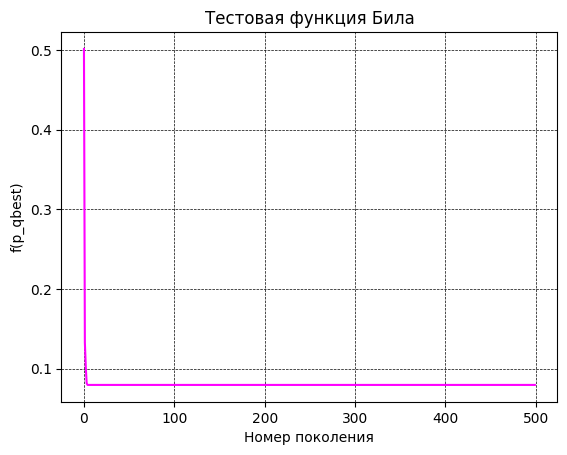

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[2.96663988 0.49594282]
The function value of pqbest:		0.0006009138695406411
Algorithm running time:			0.024250268936157227 s


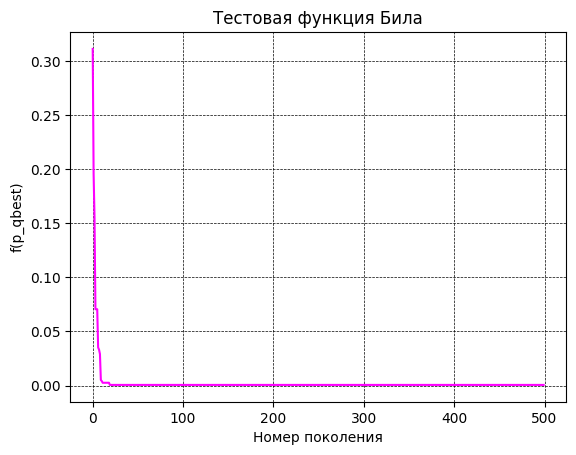

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[3.69230052 0.62135582]
The function value of pqbest:		0.04362662066441663
Algorithm running time:			0.016002893447875977 s


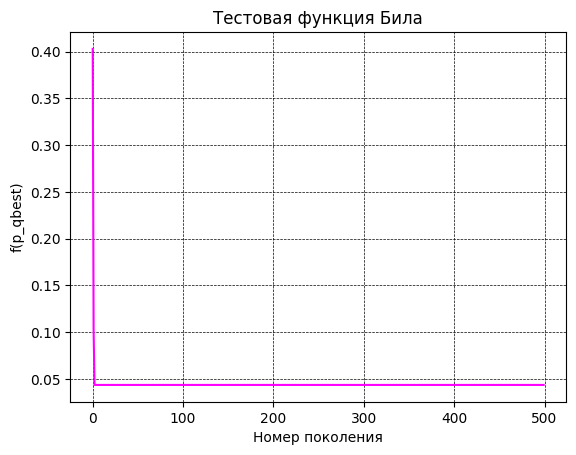

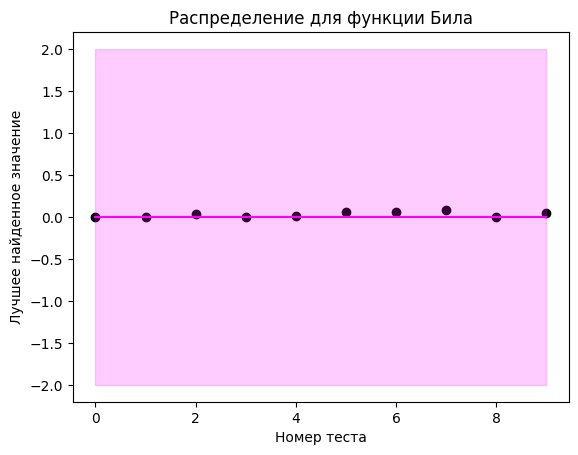

In [273]:
start_test(f5, generate_agents5, "Била", n_args_count_, iter_max_, number_of_agents_, max_weight_)

##Тестовая функция Гольдшейна-Прайса
![picture_of_Goldsheina_praisa](src/гольдшейна_прайса.png)

In [274]:
@njit
def f6(x):  # Тестовая функция гольдшейна-прайса
    result = (1 + (x[0] + x[1] + 1) ** 2 *
              (19 - 14* x[0] + 3*x[0]**2 - 14 * x[1] + 6 * x[0]*x[1] + 3 * x[1] ** 2)) * \
             (30 + (2*x[0]-3*x[1]) ** 2 * (18 - 32*x[0]+12*x[0]**2+48*x[1] - 36*x[0]*x[1] + 27*x[1]**2))
    return result

In [275]:
@njit
def generate_agents6(number_of_agents, n_args_count):
    return numpy.random.uniform(-2, 2, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[-0.01685167 -1.03967141]
The function value of pqbest:		3.6631356495130625
Algorithm running time:			0.03199648857116699 s


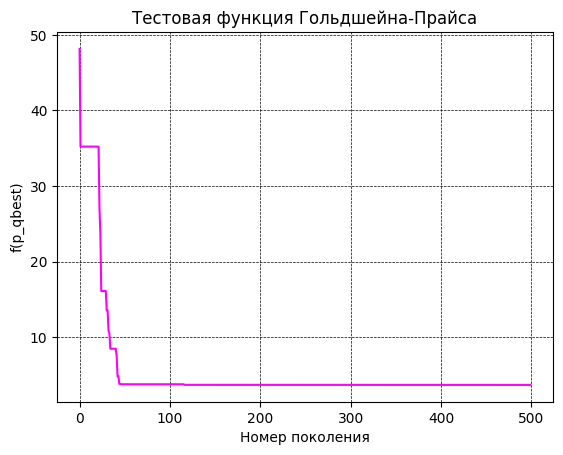

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[-0.12807453 -0.98767744]
The function value of pqbest:		8.495261819279532
Algorithm running time:			0.03198742866516113 s


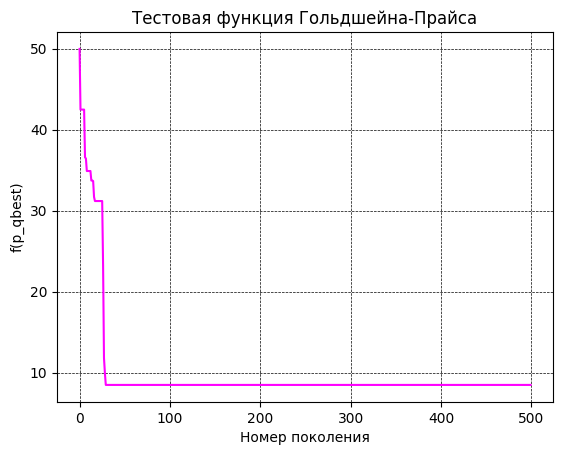

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[ 7.83198289e-04 -9.99168609e-01]
The function value of pqbest:		3.0003122672403366
Algorithm running time:			0.03999042510986328 s


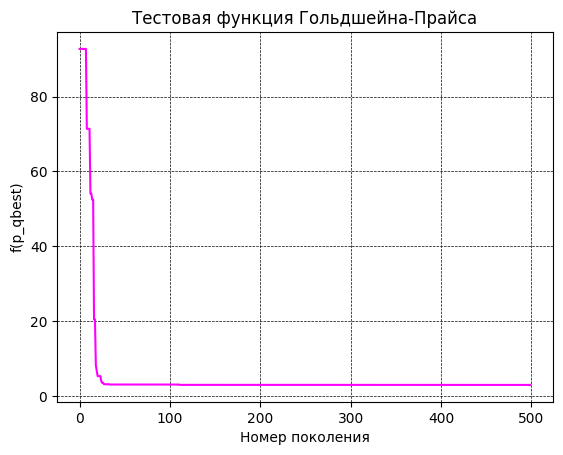

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[-0.00177859 -1.00934631]
The function value of pqbest:		3.03541859770568
Algorithm running time:			0.02400660514831543 s


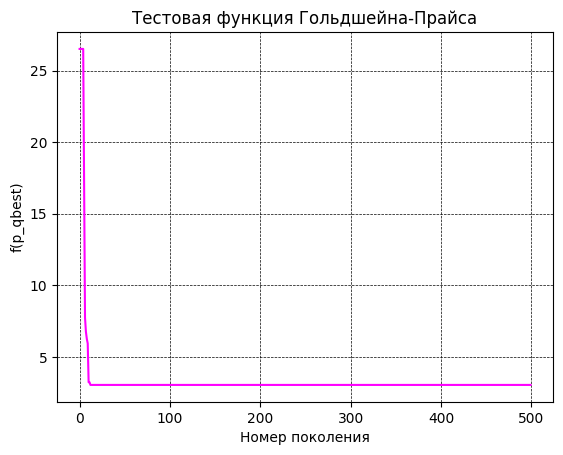

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[ 0.00307905 -1.00451471]
The function value of pqbest:		3.0143516415376337
Algorithm running time:			0.03225898742675781 s


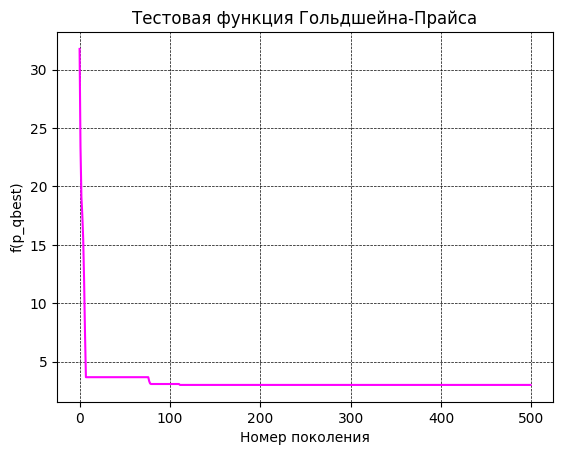

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[-0.0186782  -1.01183098]
The function value of pqbest:		3.1023682752072883
Algorithm running time:			0.03201556205749512 s


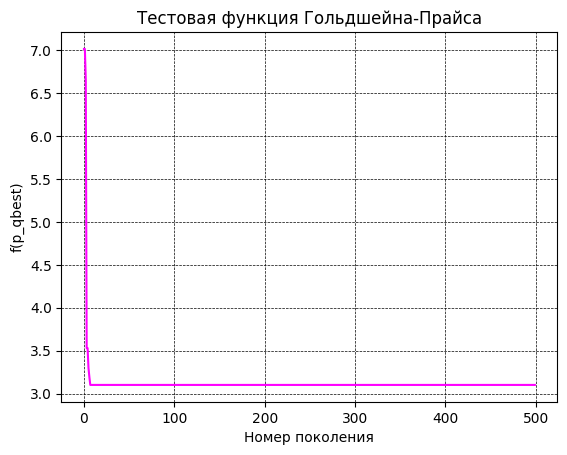

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[-0.0130886  -1.00165374]
The function value of pqbest:		3.03980519314927
Algorithm running time:			0.032016754150390625 s


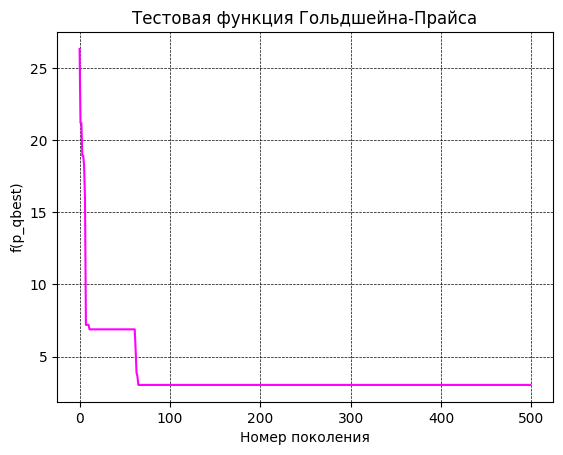

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[ 0.0505368  -1.00296471]
The function value of pqbest:		3.7370637732032055
Algorithm running time:			0.03201913833618164 s


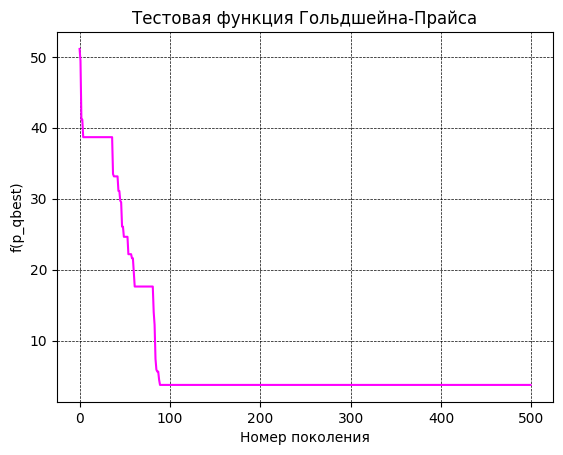

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[ 0.05693723 -0.94715837]
The function value of pqbest:		4.322031344977934
Algorithm running time:			0.023989439010620117 s


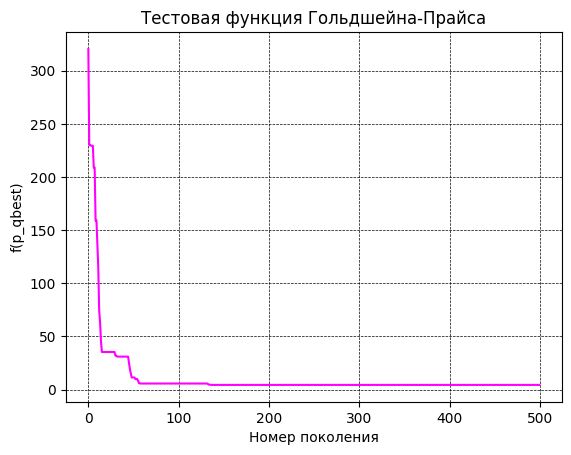

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[ 0.0381013  -0.97169038]
The function value of pqbest:		3.4620707576297387
Algorithm running time:			0.025030136108398438 s


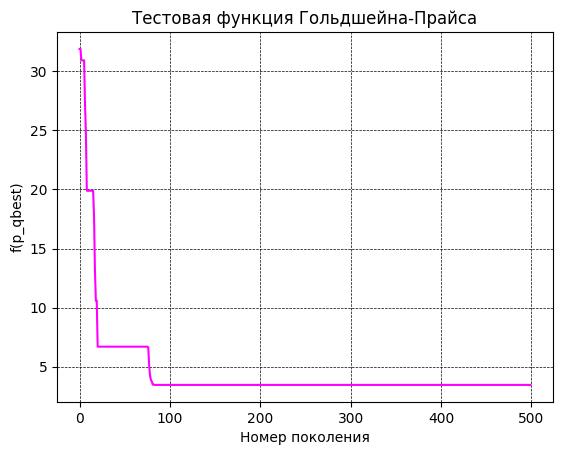

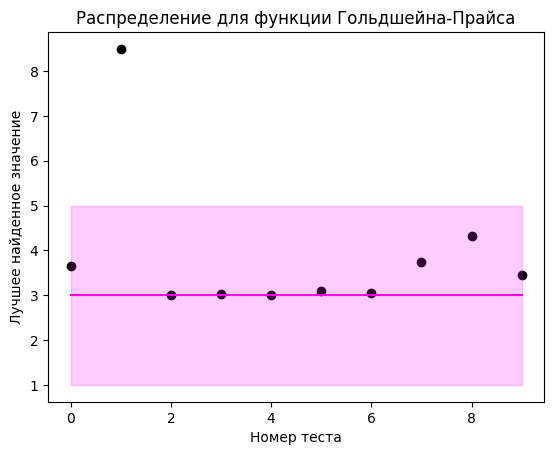

In [280]:
start_test(f6, generate_agents6, "Гольдшейна-Прайса", n_args_count_, iter_max_, number_of_agents_, max_weight_, c=3)

##Тестовая функция Бута
![picture_of_Buta](src/бута.png)

In [281]:
@njit
def f7(x):  # Тестовая функция Бута
    result = (x[0] * 2 * x[1] - 7) ** 2 + (2 * x[0] + x[1] - 5) ** 2
    return result

In [282]:
@njit
def generate_agents7(number_of_agents, n_args_count):
    return numpy.random.uniform(-10, 10, size=(number_of_agents, n_args_count))

------------------------TEST NUMBER: 1------------------------
Coordinates of p_qbest:			[0.91196773 3.72719502]
The function value of pqbest:		0.3444829141380256
Algorithm running time:			4.979571342468262 s


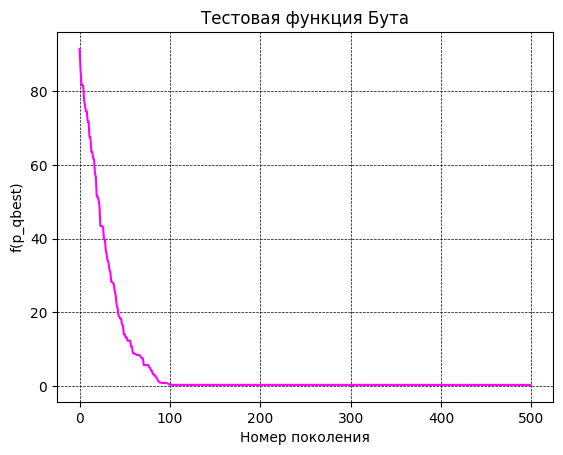

------------------------TEST NUMBER: 2------------------------
Coordinates of p_qbest:			[0.60351979 4.40978632]
The function value of pqbest:		3.1935190209775994
Algorithm running time:			0.032004356384277344 s


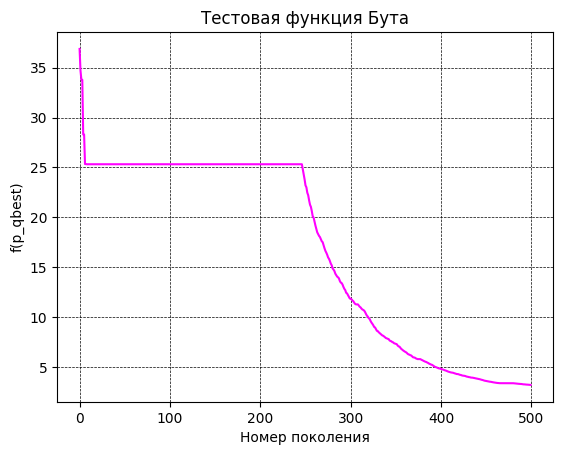

------------------------TEST NUMBER: 3------------------------
Coordinates of p_qbest:			[1.92284322 1.76798203]
The function value of pqbest:		0.4169479822362872
Algorithm running time:			0.04909539222717285 s


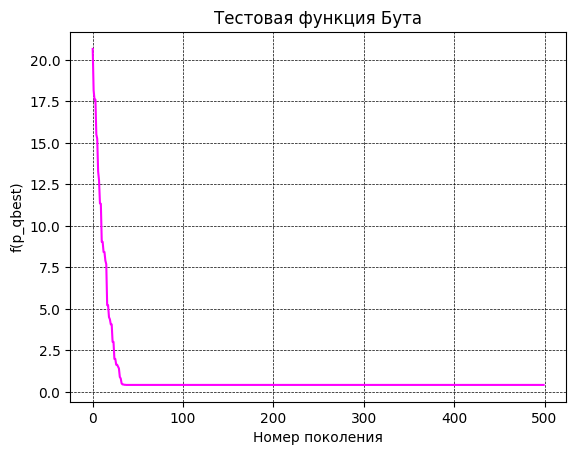

------------------------TEST NUMBER: 4------------------------
Coordinates of p_qbest:			[0.78511913 4.30615784]
The function value of pqbest:		0.8248599728366764
Algorithm running time:			0.024022340774536133 s


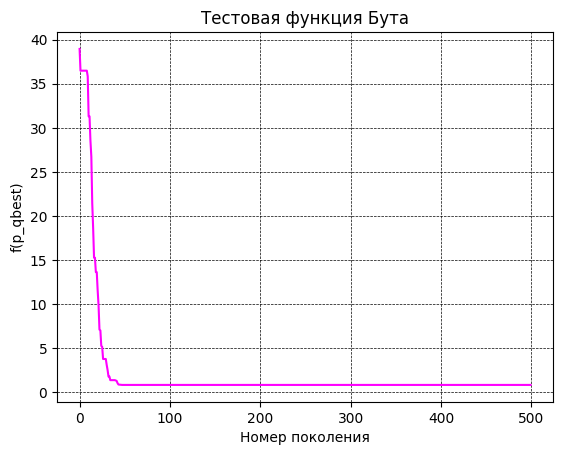

------------------------TEST NUMBER: 5------------------------
Coordinates of p_qbest:			[2.97331816 1.31949187]
The function value of pqbest:		5.8519639191404735
Algorithm running time:			0.04000449180603027 s


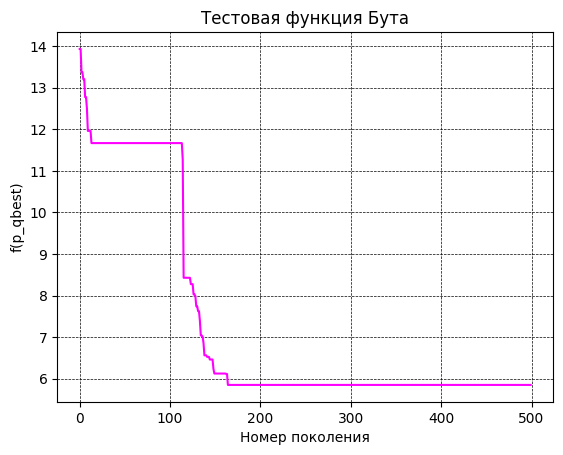

------------------------TEST NUMBER: 6------------------------
Coordinates of p_qbest:			[1.31178271 2.63134347]
The function value of pqbest:		0.07429045715087632
Algorithm running time:			0.024132490158081055 s


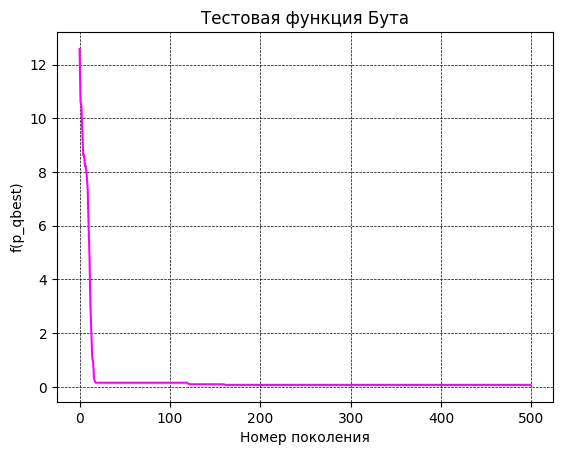

------------------------TEST NUMBER: 7------------------------
Coordinates of p_qbest:			[0.97572631 3.71326943]
The function value of pqbest:		0.5025040017133194
Algorithm running time:			0.03198647499084473 s


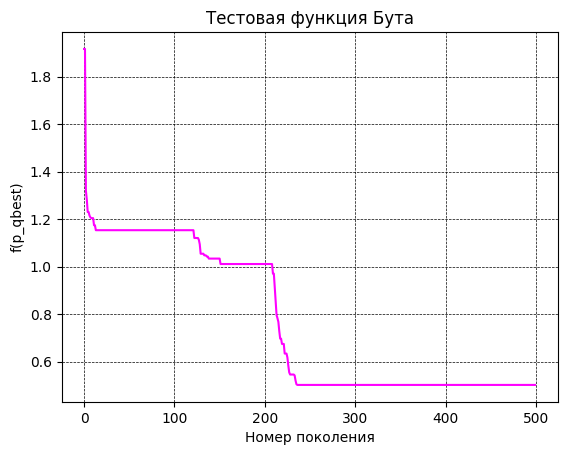

------------------------TEST NUMBER: 8------------------------
Coordinates of p_qbest:			[0.57743683 5.76031873]
The function value of pqbest:		3.7887595894066295
Algorithm running time:			0.03199267387390137 s


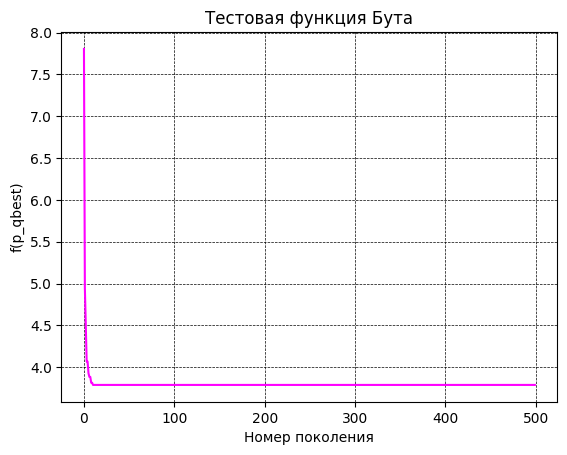

------------------------TEST NUMBER: 9------------------------
Coordinates of p_qbest:			[0.77103856 3.46634373]
The function value of pqbest:		2.737873478110384
Algorithm running time:			0.03200268745422363 s


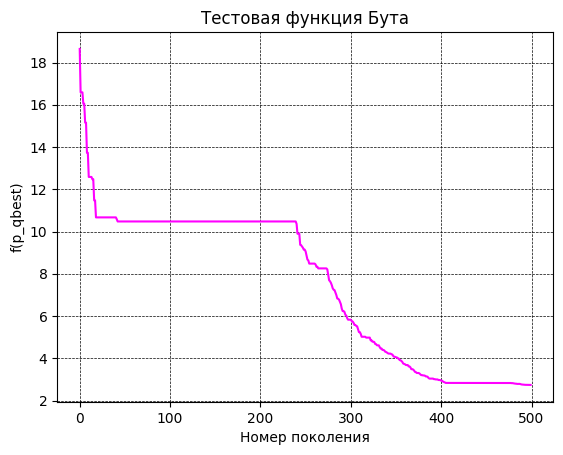

------------------------TEST NUMBER: 10------------------------
Coordinates of p_qbest:			[2.75522178 1.1109922 ]
The function value of pqbest:		3.399832895773827
Algorithm running time:			0.0320131778717041 s


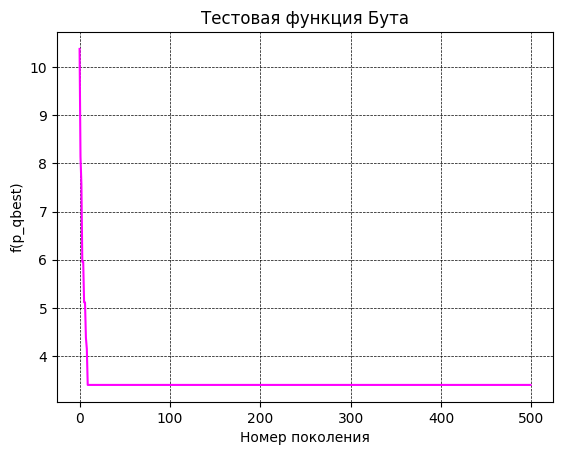

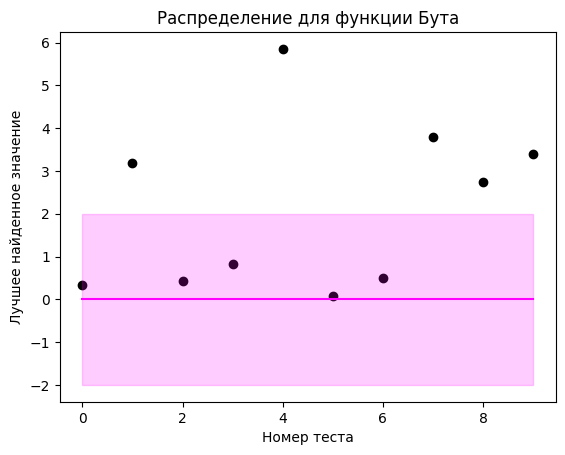

In [283]:
start_test(f7, generate_agents7, "Бута", n_args_count_, iter_max_, number_of_agents_, max_weight_)